# Análisis de rayos gamma

## 1. Cargar módulos y librerías de python

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay

from ctapipe.image import hillas_parameters, tailcuts_clean
import astropy.units as u
from lstchain.reco.disp import disp

props = dict(boxstyle='round',facecolor='white',alpha=1.0)

## 2. Caracterización de una cascada atmosférica

### 2.1 Definir parámetros para los plots

In [22]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 14

### 2.2 Cargar datos de cascada atmosférica

In [31]:
cascada = pd.read_pickle("cascada.pkl")['intensidad']
cascada

0       4.944443
1       5.794750
2       2.997210
3       2.777320
4       2.029706
          ...   
1850    4.003155
1851    0.354776
1852    1.408805
1853    3.527102
1854    4.404233
Name: intensidad, Length: 1855, dtype: float64

### 2.3 Visualizar cascada

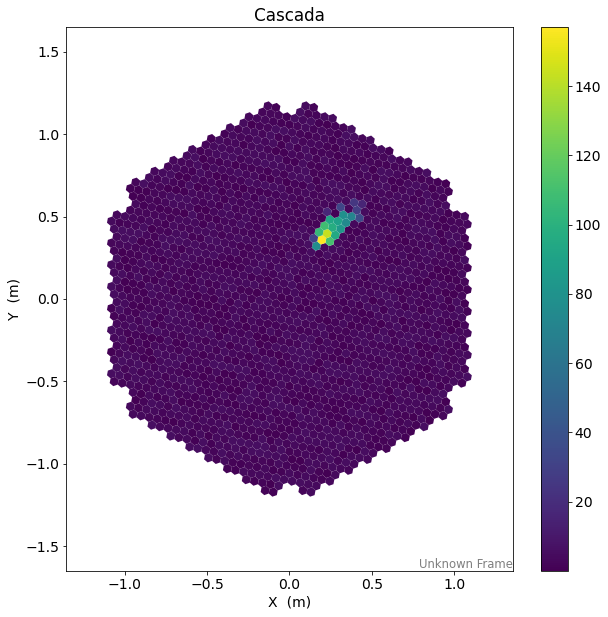

In [24]:
camera = CameraGeometry.from_name("LSTCam-002")
display = CameraDisplay(camera,title="Cascada")
display.add_colorbar()
display.image = cascada

### 2.4 Limpiar cascada

In [25]:
cleaning_method = tailcuts_clean
cleaning_parameters = {'boundary_thresh': 3,                                                                                                            
                       'picture_thresh': 6,                                                                                                             
                       'keep_isolated_pixels': False,                                                                                                   
                       'min_number_picture_neighbors': 1                                                                                                
                       }
pixeles_con_señal = cleaning_method(camera,cascada,**cleaning_parameters)
cascada_limpia = cascada                                                                                                                          
cascada_limpia[~pixeles_con_señal] = 0

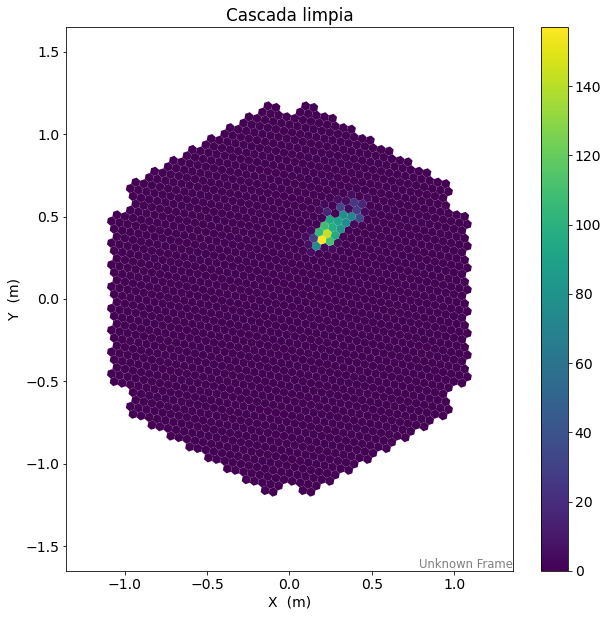

In [26]:
display = CameraDisplay(camera,title = "Cascada limpia")
display.image = cascada_limpia
display.add_colorbar()

### 2.5 Parametrizar cascada: obtención de los parámetros de Hillas

In [33]:
hillas = hillas_parameters(camera, cascada_limpia)
print(hillas)

{'intensity': 1637.4120439466851,
 'kurtosis': 2.610493652362036,
 'length': <Quantity 0.09273567 m>,
 'length_uncertainty': <Quantity 0.00145418 m>,
 'phi': <Angle 1.02272145 rad>,
 'psi': <Angle 0.74062304 rad>,
 'r': <Quantity 0.50541602 m>,
 'skewness': 0.4809935762846441,
 'width': <Quantity 0.03659092 m>,
 'width_uncertainty': <Quantity 0.00066849 m>,
 'x': <Quantity 0.26334451 m>,
 'y': <Quantity 0.43138732 m>}


### 2.6 Cálculo de la posición esperada de la fuente

In [34]:
src_x, src_y = 0*u.m,0*u.m
disp_dx, disp_dy, disp_norm, disp_angle, disp_sign = disp(hillas.x.value, hillas.y.value, src_x.value, src_y.value)

### 2.7 Cálculo del ángulo alpha: ángulo entre los vectores reconstruído y esperado

In [35]:
def calc_alpha(Xcog,Xreco,Ycog,Yreco,Xexp,Yexp):
    # Takes Xcog,Xreco,Ycog,Yreco,Xexp,Yexp in camera coords calculate the alpha angle in rad
    cos_psi = (Xcog-Xexp)/np.sqrt((Xcog-Xexp)**2 + (Ycog-Yexp)**2)
    sin_psi = (Ycog-Yexp)/np.sqrt((Xcog-Xexp)**2 + (Ycog-Yexp)**2)
    alpha = np.arccos(((Xcog-Xreco)*cos_psi + (Ycog-Yreco)*sin_psi) / np.sqrt((Xcog-Xreco)**2 +(Ycog-Yreco)**2))
    alpha = np.rad2deg(alpha)
    alpha = alpha * (alpha < 90) + (180 - alpha) * (alpha >= 90)
    alpha = np.deg2rad(alpha)
    return alpha

### 2.8 Visualización de la cascada parametrizada

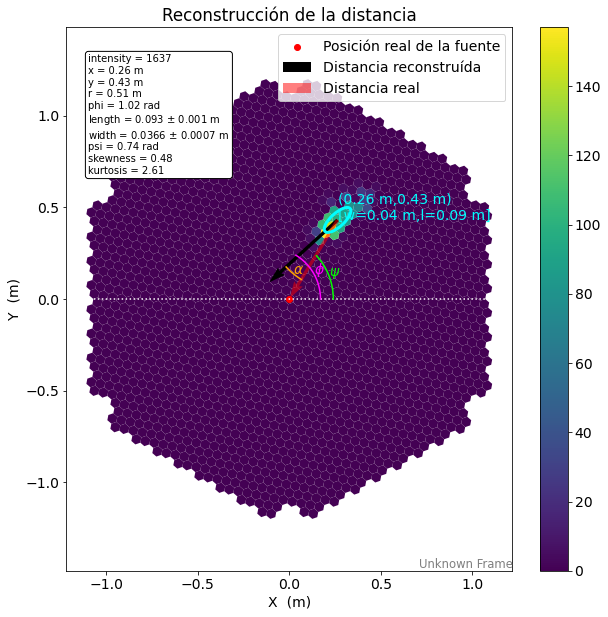

In [36]:
ax = plt.subplot(1,1,1)
display = CameraDisplay(camera,title = "Reconstrucción de la distancia")
display.add_colorbar()
display.image = cascada_limpia
display.overlay_moments(hillas, color='cyan', linewidth=3)
plt.scatter(src_x, src_y, color='red', label='Posición real de la fuente')
uu = disp_sign * disp_norm * np.cos(hillas.psi.value)
vv = disp_sign * disp_norm * np.sin(hillas.psi.value)

plt.quiver(hillas.x.value, hillas.y.value, uu, vv, units='xy', scale=np.sqrt((hillas.x.value-uu)**2 + (hillas.y.value-vv)**2),label= "Distancia reconstruída")
plt.quiver(hillas.x.value, hillas.y.value, disp_dx, disp_dy,units='xy', scale=np.sqrt((hillas.x.value-disp_dx)**2 + (hillas.y.value-disp_dy)**2),color='red',alpha=0.5,label= "Distancia real")
plt.axhline(0,linestyle='dotted',color='w')

phi = np.linspace(0,hillas.phi.value,100)
r = 0.28
x1 = r * np.cos(phi) + hillas.x.value+uu
x2 = r * np.sin(phi) + 0
plt.plot(x1, x2, color='magenta')
plt.text(np.median(x1),np.median(x2),r'$\phi$',color='magenta')

psi = np.linspace(0,hillas.psi.value,100)
r = 0.35
x1 = r * np.cos(psi) + hillas.x.value+uu
x2 = r * np.sin(psi) + 0
plt.plot(x1, x2, color='lime')
plt.text(np.median(x1),np.median(x2),r'$\psi$',color='lime')

angulo_alpha = calc_alpha(hillas.x.value,hillas.x.value+uu,hillas.y.value,hillas.y.value+vv,0,0)
angulos_alpha = np.linspace(np.pi+hillas.psi.value,np.pi+hillas.psi.value+angulo_alpha,100)

r = 0.38
x1 = r * np.cos(angulos_alpha) + hillas.x.value
x2 = r * np.sin(angulos_alpha) + hillas.y.value
plt.plot(x1, x2, color='orange')
plt.text(np.median(x1),np.median(x2),r'$\alpha$',color='orange')

textstr = 'intensity = %.0f \n'%hillas.intensity+'x = %.2f m \n'%hillas.x.value+'y = %.2f m \n'%hillas.y.value+'r = %.2f m \n'%hillas.r.value+'phi = %.2f rad \n'%hillas.phi.value+r'length = %.3f $\pm$ %.3f m'%(hillas.length.value,hillas.length_uncertainty.value)+'\n'+r'width = %.4f $\pm$ %.4f m'%(hillas.width.value,hillas.width_uncertainty.value)+'\n'+ 'psi = %.2f rad \n'%hillas.psi.value+'skewness = %.2f \n'%hillas.skewness+'kurtosis = %.2f'%hillas.kurtosis
ax.text(0.05, 0.95, textstr, fontsize=10, transform=ax.transAxes, verticalalignment='top', bbox=props)

plt.legend()

### Preguntas:
#### ¿Qué pasaría si la elipse fuese un círculo?
#### ¿Qué implica que el ángulo alpha sea más (o menos) cercano a cero?

## 3. Detección de una fuente de rayos gamma a partir de observaciones ON/OFF

### 3.1 Definir parámetros para los plots

In [47]:
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 14

### 3.2 Cargar datos de ON y OFF de la Nebulosa del Crab

In [48]:
OFF = pd.read_pickle("Crab_OFF.pkl")
OFF

,leakage_intensity,gammaness,alpha,theta2,n_islands,width_length
0,0.046353,0.935985,19.255336,1.641581,1.000000,0.845432
1,0.159807,0.900920,64.054302,1.516478,1.000000,0.925414
2,0.165270,0.999104,37.257305,0.518690,1.000000,0.330329
3,0.046582,0.863889,16.157969,0.075573,1.000000,0.490426
4,0.025087,0.840434,5.504227,1.280378,1.000000,0.755724
...,...,...,...,...,...,...
164170,0.831212,0.041776,35.517235,0.928402,90.110613,0.057164
164171,0.353188,0.173477,89.482819,1.149435,21.707483,0.074595
164172,0.346797,0.005194,37.860319,0.567302,60.827518,0.029532
164173,0.930952,0.275988,48.364451,0.985073,108.243822,0.066863


In [49]:
ON = pd.read_pickle("Crab_ON.pkl")
ON

,leakage_intensity,gammaness,alpha,theta2,n_islands,width_length
0,0.162524,0.926616,1.691446,0.031240,1.000000,0.431357
1,0.023539,0.845515,3.855352,0.005252,1.000000,0.254941
2,0.133873,0.948496,1.820932,0.051776,1.000000,0.575393
3,0.066437,0.997446,0.141957,0.013255,1.000000,0.938384
4,0.190280,0.874168,0.553856,0.190645,1.000000,0.213658
...,...,...,...,...,...,...
166007,0.363682,0.228089,58.656723,0.546258,71.543554,0.020452
166008,0.255366,0.168792,34.429566,0.572900,105.195936,0.031613
166009,0.447585,0.072250,70.171281,0.277662,38.726080,0.045078
166010,0.507836,0.232518,55.164905,1.640121,63.033022,0.021836


### 3.3 Limpiar datos:
Para limpiar cascadas que se salgan por el borde de la cámara -> leakage_intensity <= 20%

Para limpiar cascadas que tengan más de una posible 'isla' o elipse -> n_islands == 1

Para limpiar cascadas que sean demasiado circulares -> width/length >= 0.1

Para limpiar cascadas que las simulaciones MC han caracterizado como poco probables de ser gammas -> gammaness >= 80%

In [50]:
OFF = OFF[OFF['leakage_intensity']<= 0.2]
OFF = OFF[OFF['n_islands'] == 1]
OFF = OFF[OFF['width_length'] >= 0.1]
OFF = OFF[OFF['gammaness'] >= 0.8]
OFF

,leakage_intensity,gammaness,alpha,theta2,n_islands,width_length
0,0.046353,0.935985,19.255336,1.641581,1.0,0.845432
1,0.159807,0.900920,64.054302,1.516478,1.0,0.925414
2,0.165270,0.999104,37.257305,0.518690,1.0,0.330329
3,0.046582,0.863889,16.157969,0.075573,1.0,0.490426
4,0.025087,0.840434,5.504227,1.280378,1.0,0.755724
...,...,...,...,...,...,...
120991,0.053152,0.806238,26.255740,1.187294,1.0,0.672248
120992,0.046264,0.917144,89.206670,1.214825,1.0,0.641379
120993,0.112758,0.983494,53.885440,1.232634,1.0,0.582395
120994,0.148882,0.857707,7.607592,0.120074,1.0,0.485358


In [51]:
ON = ON[ON['leakage_intensity']<= 0.2]
ON = ON[ON['n_islands'] == 1]
ON = ON[ON['width_length'] >= 0.1]
ON = ON[ON['gammaness'] >= 0.8]
ON

,leakage_intensity,gammaness,alpha,theta2,n_islands,width_length
0,0.162524,0.926616,1.691446,0.031240,1.0,0.431357
1,0.023539,0.845515,3.855352,0.005252,1.0,0.254941
2,0.133873,0.948496,1.820932,0.051776,1.0,0.575393
3,0.066437,0.997446,0.141957,0.013255,1.0,0.938384
4,0.190280,0.874168,0.553856,0.190645,1.0,0.213658
...,...,...,...,...,...,...
122345,0.078513,0.871224,58.088676,1.504359,1.0,0.643092
122346,0.163994,0.892554,15.658814,0.650442,1.0,0.163950
122347,0.192145,0.834038,46.702360,1.641356,1.0,0.213384
122348,0.108537,0.803744,38.038894,1.691174,1.0,0.175738


### 3.4 Histograma del ángulo $\alpha$

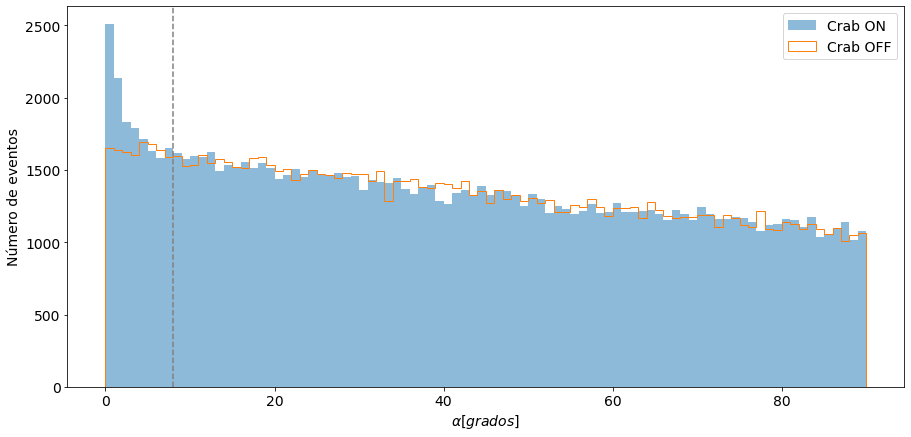

In [52]:
corte_alpha = 8
ax = plt.subplot(1, 1, 1)
plt.hist(ON['alpha'],bins = 90,label='Crab ON',alpha=0.5)
plt.hist(OFF['alpha'],bins = 90,histtype='step',label='Crab OFF')
plt.axvline(corte_alpha,linestyle='--',color='grey')
#textstr = r'Significance = %.2f $\sigma$'%Significance(len(ON['alpha'][ON['alpha']<=corte_alpha]),len(OFF['alpha'][OFF['alpha']<=corte_alpha]),len(ON['alpha'][ON['alpha']>corte_alpha])/len(OFF['alpha'][OFF['alpha']>corte_alpha]))
#ax.text(0.05, 0.95, textstr, fontsize=10, transform=ax.transAxes, verticalalignment='top', bbox=props)
plt.xlabel(r'$\alpha[grados]$')
plt.ylabel('Número de eventos')
plt.legend()

### 3.5 Histograma del ángulo $\theta^2$

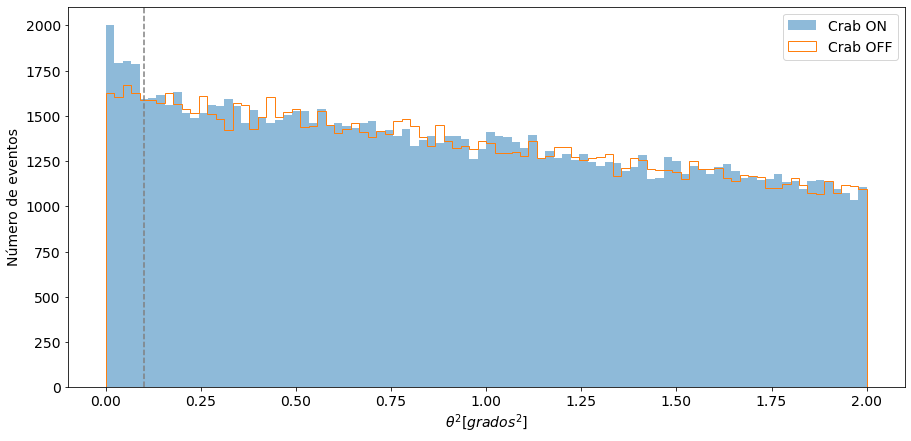

In [53]:
corte_theta2 = 0.1
ax = plt.subplot(1, 1, 1)
plt.hist(ON['theta2'],bins = 90,label='Crab ON',alpha=0.5)
plt.hist(OFF['theta2'],bins = 90, histtype='step',label='Crab OFF')
plt.axvline(corte_theta2,linestyle='--',color='grey')
#textstr = r'Significance = %.2f $\sigma$'%Significance(len(ON['theta2'][ON['theta2']<=corte_theta2]),len(OFF['theta2'][OFF['theta2']<=corte_theta2]),len(ON['theta2'][ON['theta2']>corte_theta2])/len(OFF['theta2'][OFF['theta2']>corte_theta2]))
#ax.text(0.05, 0.95, textstr, fontsize=10, transform=ax.transAxes, verticalalignment='top', bbox=props)
plt.xlabel(r'$\theta^2[grados^2]$')
plt.ylabel('Número de eventos')
plt.legend()

In [ ]:
### Preguntas:
####
#### ¿Se detecta la Nebulosa del Crab?
#### ¿Por qué decrece el número de eventos para ángulos grandes?

In [14]:
def Significance(Non,Noff,n):
    return np.sqrt(2*((Non*np.log(((1+n)*Non)/(n*(Non+Noff))))+(Noff*np.log(((1+n)*Noff)/(Non+Noff)))))